# Predicting Heart Disease
This notebook uses several Python based Machine Leanrning and data science tools to predict whether a patient has heart disesase. This is not a diagnostic tool.

The following approach will be used
1. Problem Definition (see above)
2. Data Exploration
3. Evaluation 
4. What features contribute most
5. Modelling the data
6. Validation and Improvement

Original data from: https://archive.ics.uci.edu/ml/datasets/heart+disease

Data in CSV form from: https://www.kaggle.com/ronitf/heart-disease-uci

The data has 76 total columns, however only 14 of them are used in published experiments. I will also be using this 14 column subset.

1. age
2. sex
3. chest pain type (4 values)
4. resting blood pressure
5. serum cholestoral in mg/dl
6. fasting blood sugar > 120 mg/dl
7. resting electrocardiographic results (values 0,1,2)
8. maximum heart rate achieved
9. exercise induced angina
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment
12. number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
14. target

# Imports

In [26]:
#EDA and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

## Load Data

In [27]:
df = pd.read_csv("heart-disease(1).csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# EDA

### EDA Checklist

1. What questions are we trying to solve?
2. What kind of data do we have?
3. What's missing?
4. What are the outliers?

1    165
0    138
Name: target, dtype: int64

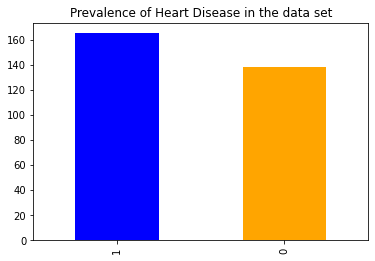

In [28]:
# What do the classes we're trying to predict look like?
ax = df["target"].value_counts().plot(kind="bar", color=["blue", "orange"], title="Prevalence of Heart Disease in the data set")

df["target"].value_counts()

It looks like the two classes are (relatively) even. 0 = no heart disease, 1 = heart disease. Can we do better than roughly a coinflip?

What kind of data do we have?

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


This implies that all the columns are numeric. This is technically true, but some columns are categorically represented by numbers. 'cp' (chest pain) and 'thal' (Thalium stress test result) are categorical columns, and we'll need to encode them as such later on. 

Any missing values?

In [30]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

No missing values, which saves us a bit of imputing later on. 

In [31]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


How does heart disease scale with the sex of the patients in the study? Male = 1, Female = 0

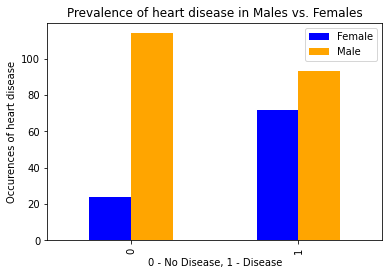

In [32]:
pd.crosstab(df.target, df.sex)
pd.crosstab(df.target, df.sex).plot(kind="bar", color=["blue", "orange"], title="Prevalence of heart disease in Males vs. Females")
plt.ylabel("Occurences of heart disease")
plt.xlabel("0 - No Disease, 1 - Disease")
plt.legend(["Female", "Male"]);

If a patient in the dataset is female, there is a (72/24+72) = 75% chance that patient has heart disease. 
For males (93/114+93) = 45% chance that a male in the dataset has heart disease.

## Age vs Max Heart Rate for Heart Disease

For the cell below, thalach is maximum heart rate achieved during the study

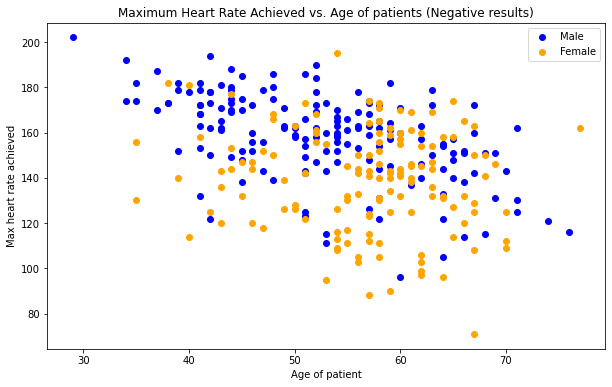

In [33]:
plt.figure(figsize=(10,6))

#Scatter plot with positive examples
plt.scatter(df.age[df.target==1],
           df.thalach[df.target==1], 
           color = ["blue"])
plt.title("Maximum Heart Rate Achieved vs. Age of patients (Positive results)")

#Scatter with negative examples
plt.scatter(df.age[df.target==0],
           df.thalach[df.target==0],
           color = ["Orange"])
                    
                    
                    
plt.title("Maximum Heart Rate Achieved vs. Age of patients (Negative results)")
plt.legend(["Male","Female"])
plt.xlabel("Age of patient")
plt.ylabel("Max heart rate achieved");

In this case, it's tough to say that any correlation exists. There appears to be a general downward trend for both positve cases and negative cases.

## Does chest pain correlate to heart disease?

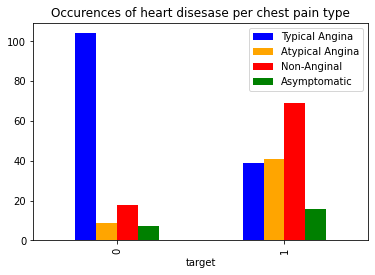

In [34]:
pd.crosstab(df.cp, df.target)
pd.crosstab(df.target, df.cp).plot(kind="bar", color=["blue", "orange", "Red", "Green"])
plt.legend(["Typical Angina", "Atypical Angina", "Non-Anginal", "Asymptomatic"])
plt.title("Occurences of heart disesase per chest pain type");

It looks like there are a lot of patients without heart disease who suffer from Angina, while the most common form of pain for those with heart disease is Non-Anginal Pain

### Correlation Matrix

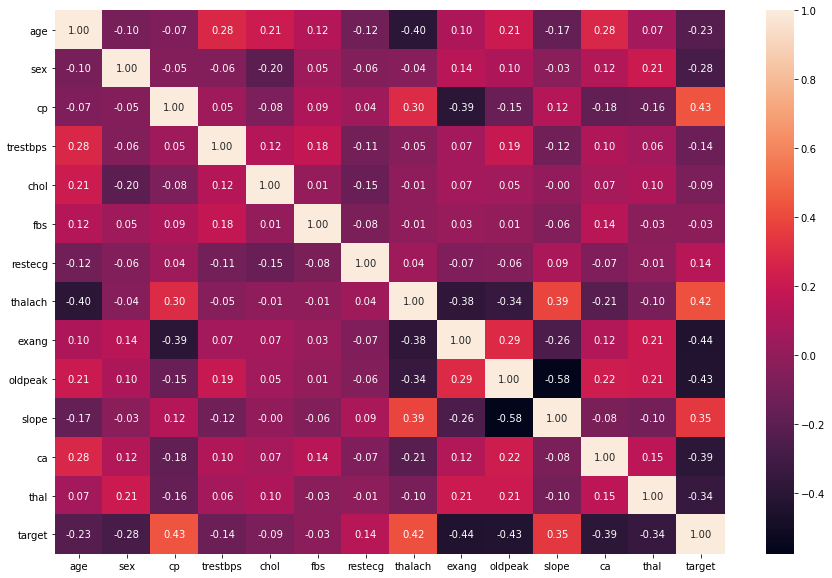

In [35]:
corr_matrix = df.corr()
plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f")

Based on the correlation matrix, there are only a few features that don't correlate somewhat (positively or negatively). Maybe we can remove chol and fbs from the training and test data later? This is something to look into, at the very least.

# Now let's actually do some modelling

In [36]:
X = df.drop("target", axis=1)
y = df["target"]

#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)




# One Hot Encoding to handle categorical data

In [123]:
one_hot = OneHotEncoder(handle_unknown='ignore')
cat_features = ["cp", "thal"]
transformer = ColumnTransformer([("one_hot", one_hot, cat_features)], remainder="passthrough")
X_train_onehot = pd.DataFrame(transformer.fit_transform(X_train))
X_test_onehot = pd.DataFrame(transformer.fit_transform(X_test))


I'm going to scale the data to a 0-1 scale. While technically not needed for all algorithms, it doesn't hurt and will allow other algorithms to be used if we so choose. Be sure to scale train and test splits separately, to avoid leakage.

In [125]:
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_onehot))
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test_onehot))

X_train_scaled.index = X_train.index


Testing on 3 different models
1. K Nearest Neighbors
2. Random Forest
3. Logistic Regression

Scaling was really done for the sake of K Nearest Neighbors, which I believe requires some sort of scaling

In [39]:
models = {"Logistic Regression": LogisticRegression(),
         "KNN": KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier()}

def fit_and_score(models, X_train, X_test, y_train, Y_test):
    """
    Fit and scores given machine learning models on the given input data
    """
    
    #set random seed for reproducibility
    np.random.seed(42)
    #make dictionary to keeo scores
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [40]:
model_scores = fit_and_score(models, X_train_scaled, X_test_scaled, y_train, y_test)
model_scores

{'Logistic Regression': 0.9016393442622951,
 'KNN': 0.8360655737704918,
 'Random Forest': 0.8852459016393442}

### Quick plot of these results

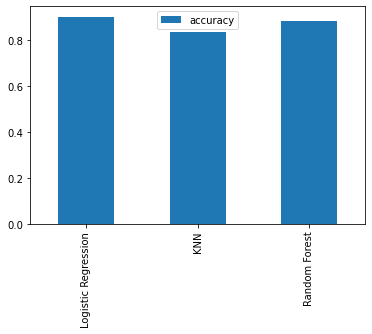

In [41]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

Accuracy is not necessarily the best measure of a model, but it isn't a waste of time to look at it either. Initially, this shows RandomForest doing the "best" and Logistic Regression doing the "worst". Now with a baseline, I can tune the models.

# Hyperparameter tuning

The max accuracy for KNN is 86.89% 


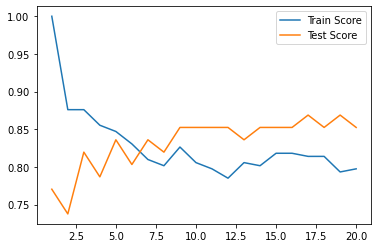

In [42]:
#Tuning KNN
train_scores = []
test_scores = []
np.random.seed(42)
#Create a different list for n neighbors
neighbors = range(1,21)
knn = KNeighborsClassifier()

#loop over values for neighbors
for i in neighbors:
    knn.set_params(n_neighbors=i)
    
    knn.fit(X_train_scaled, y_train)
    
    train_scores.append(knn.score(X_train_scaled, y_train))
    
    test_scores.append(knn.score(X_test_scaled, y_test))

plt.plot(neighbors, train_scores, label = "Train Score")
plt.plot(neighbors, test_scores, label = "Test Score")
plt.legend();
print(f"The max accuracy for KNN is {max(test_scores)*100:.2f}% ")

By changing the number of neighbors, I'm able to improve the accuracy of the KNN algorithm a bit but not incredibly much. Tuning by hand is largely inefficient. We'll come back to this in a bit. Let's take a look at the other two models now.

# Using RandomizedSearchCV to tune hyperparameters

In [43]:
# create a hyperparameter grid for logisticRegression

log_reg_grid = {"C":np.logspace(-4, 4, 20),
               "solver": ["liblinear"]}

#create grid for RandomForest

rf_grid = {"n_estimators":np.arange(10, 1000, 50),
          "max_depth":[None, 3, 5, 10],
          "min_samples_split":np.arange(2,20,2),
          "min_samples_leaf": np.arange(1,20,2)}

In [44]:
#Tune Logistic Regression

np.random.seed(42)

rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                               param_distributions = log_reg_grid,
                               cv=5, 
                               n_iter=20,
                               verbose=True)
#fit hyperparamter search model for Logistic Regression
rs_log_reg.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [45]:
rs_log_reg.score(X_test_scaled, y_test)

0.8688524590163934

It looks a little worse. Trying RandomForest now

In [46]:
np.random.seed(42)

rs_rf = RandomizedSearchCV(RandomForestClassifier(), 
                          param_distributions=rf_grid, 
                          cv=5,
                          n_iter=20,
                          verbose=True)
rs_rf.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [47]:
rs_rf.best_params_
rs_rf.score(X_test_scaled, y_test)

0.8852459016393442

About the same score as before the tuning. Randomly searching over parameter space isn't seeming so hot. Can we do this a little more exhaustively?

# Hyperparameter Tuning with GridSearchCV

In [48]:
# different hyperparameter grid for Logistic Regression

In [51]:
log_reg_grid = {'penalty' : ['l1', 'l2'],
                'C' : np.logspace(-4, 4, 30),
                'solver' : ['liblinear']}

    
gs_log_reg = GridSearchCV(LogisticRegression(),
                         param_grid=log_reg_grid,
                         cv=5,
                         verbose=True)
gs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=True)

In [52]:
#Best Hyperparameters
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'penalty': 'l2', 'solver': 'liblinear'}

In [53]:
#Evaluate using best parameters
gs_log_reg.score(X_test, y_test)

0.8852459016393442

Despite the searches done, it appears as though the barebones default parameters provide the greatest accuracy. Again, accuracy is not the end all be all metric, but it is a useful staring place.

## What metrics can be used besides accuracy?
 * ROC Curve and AUC Score
 * Confusion Matrix
 * Classification Report
 * Precision
 * Recall
 * f1 score

In [54]:
y_preds = gs_log_reg.predict(X_test)

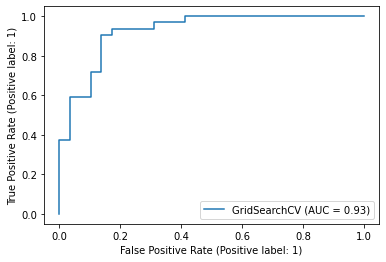

In [56]:
#plot ROC Curve and calculate AUC metric
plot_roc_curve(gs_log_reg, X_test, y_test)

A perfect model would achieve an AUC score of 1.0, so 0.93 isn't looking terribly bad here. This is why we say that accuracy isn't the end all be all. While this AUC score can improve, I'm not too unhappy with it!

In [57]:
print(confusion_matrix(y_test, y_preds))

[[25  4]
 [ 3 29]]


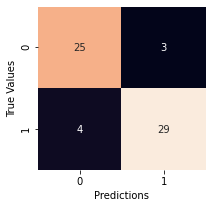

In [60]:
def plot_conf_mat(y_preds, y_test):
    """
    Plot a nice confusion matrix using seaborn's confusion matrix
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(y_preds, y_test),
                    annot=True, 
                    cbar=False)
    plt.xlabel("Predictions")
    plt.ylabel("True Values")

plot_conf_mat(y_preds, y_test)

The off diagonals give the false positives and false negatives that the model predicts. False positives in upper right, false negatives in bottom left. Neither are good to get (obviously) and a perfect model would show zero for both boxes.

The ROC curve and confusion matrix tell us largely similar things, as a ROC curve is computed from knowing the False Positive Rate and True Positive rate. Since out AUC score is decent and we see few false positives on this matrix, we start to develop a better sense for our models ability to make predictions.



In [61]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



These scores are nice to have, but I'd really like cross-validated scores.

In [71]:
clf = LogisticRegression(C = 0.20433597178569418, solver = 'liblinear', penalty='l2')

In [80]:
#Cross-Validated Accuracy
cv_acc = cross_val_score(clf,
                         X_train_scaled, 
                        y_train,
                        scoring="accuracy")

cv_acc = np.mean(cv_acc)

In [81]:
#Cross Valiodated Precision
cv_prec = cross_val_score(clf,
                         X_train_scaled, 
                        y_train,
                        scoring="precision")
cv_prec = np.mean(cv_prec)

In [82]:
#Cross Validated Recall
cv_rec = cross_val_score(clf,
                         X_train_scaled, 
                        y_train,
                        scoring="recall")
cv_rec = np.mean(cv_rec)

In [83]:
#Cross Validated f1 score
cv_f1 = cross_val_score(clf,
                         X_train_scaled, 
                        y_train,
                        scoring="f1")
cv_f1 = np.mean(cv_f1)

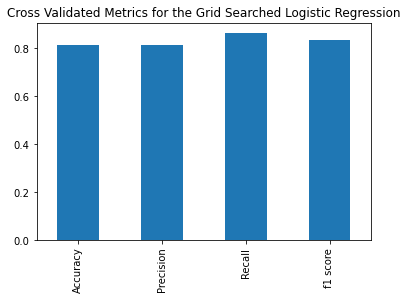

In [93]:
cv_metrics = pd.DataFrame({
    "Accuracy":cv_acc,
    "Precision":cv_prec,
    "Recall": cv_rec,
    "f1 score": cv_f1}, index=[0])

cv_metrics.T.plot.bar(title="Cross Validated Metrics for the Grid Searched Logistic Regression", legend=False);

All the scores return greater than 0.8, so I am happy enough with that at this time. Finally, I need to determine which of the features are most important to this model.

# Feature Importance

In [132]:
clf.fit(X_train_scaled, y_train);

In [135]:
clf.coef_

array([[-0.70688047,  0.22009192,  0.48085622,  0.22751685,  0.03911276,
        -0.03342298,  0.7416684 , -0.52577367, -0.20936973, -0.54774858,
        -0.19709415, -0.06177853,  0.0754866 ,  0.31242153,  0.57137937,
        -0.72059267, -0.61103613,  0.74919041, -0.89681162]])

In [137]:
#match coefs to columns
feature_dict = dict(zip(X_train_scaled.columns, list(clf.coef_[0])))
feature_dict

{0: -0.7068804721978982,
 1: 0.22009191739655296,
 2: 0.48085622356312424,
 3: 0.22751684586847726,
 4: 0.03911275821905419,
 5: -0.03342297662989243,
 6: 0.7416684032647027,
 7: -0.5257736702236087,
 8: -0.20936973310598261,
 9: -0.5477485783332199,
 10: -0.1970941483151276,
 11: -0.06177853372623414,
 12: 0.07548660449768592,
 13: 0.31242153464812944,
 14: 0.5713793674923487,
 15: -0.7205926672967589,
 16: -0.6110361311833107,
 17: 0.749190406818568,
 18: -0.8968116152578375}

This isn't necessarily a terribly helpful way to see this data, for two reasons. 
1. The OHE removed labels and knowing what numbers correspond to what isn't immediately obvious
2. A graph would be nicer

I know how to solve one of these two problems

<AxesSubplot:title={'center':'Feature Importance'}>

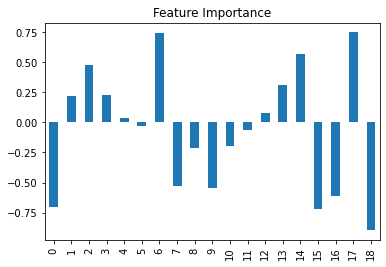

In [138]:
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Feature Importance", legend=False)

I will work on a way to make this clearer as soon as I figure out how